In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA, NMF
from matplotlib import animation
from scipy.ndimage import gaussian_filter, convolve1d
from scipy.signal import convolve2d
from scipy.stats import zscore
import os

from patchnmf.analyse.nmf import censored_lstsq, censored_nnlstsq, cv_pca
from patchnmf.analyse.compute import downsample_tiff_avg, compute_nmfpx_blur_thr, get_loading_times
from patchnmf.simulate import poiss_train
from patchnmf.plot import plot_nmfpx_blur_thr, plot_roi_loading_time, plot_roi_loading_time

# for cvNMF
from numpy.random import randn, rand
from scipy.optimize import minimize
from patchnmf.analyse.nnls import nnlsm_blockpivot as nnlstsq
import itertools
from scipy.spatial.distance import cdist

# reload code if library changes
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Simulating data

In [2]:
def make_sim_path(sim_id):
    sim_path = f'../data/{sim_id}'
    if not os.path.exists(sim_path):
        os.mkdir(sim_path)
        
    return sim_path

In [3]:
# running simulation
def run_simulation(params):
    # t = np.arange(0,params.t_max)
    movie_blank = np.zeros((params.xy_px, params.xy_px, params.t_max))
    movie = np.copy(movie_blank)

    truth_ts = []
    truth_pxs = []

    act_kernel = np.exp(-np.arange(0,params.kernel_range)/params.act_tau)

    for i in range(params.n_patches):
        # randomly generating patch in pixel space
        patch_d = random.randrange(params.patch_size_min, params.patch_size_max)
        patch_x = random.randrange(patch_d, params.xy_px-patch_d)
        patch_y = random.randrange(patch_d, params.xy_px-patch_d)

        # randomly generating the activation of patch in time
        act_t,_ = poiss_train(params.poiss_tau, t_max=params.t_max)

        # computing contribution of patch to movie and adding to final movie
        patch_movie = np.copy(movie_blank)
        patch_movie[patch_x-patch_d:patch_x+patch_d, patch_y-patch_d:patch_y+patch_d, np.round(act_t).astype(int)] = params.act_scaling
        patch_movie = convolve1d(patch_movie, act_kernel) # adding 'GCamp decay'
        patch_movie = gaussian_filter(patch_movie, params.smoothing_sigma) # smoothing square in image
        movie += patch_movie # accumulate contribution of all patches in 'movie'

        # getting and saving ground truth
        truth_px = patch_movie[:,:,np.round(act_t).astype(int)[0]]
        truth_t = np.mean(patch_movie,(0,1))
        truth_ts.append(truth_t)
        truth_pxs.append(truth_px)

    # adding noise
    noise_mask = np.random.poisson(params.im_noise, movie.shape)
    movie += noise_mask
    
    movie = movie.transpose((2, 0, 1))
    
    return truth_pxs, truth_ts, movie

In [4]:
def reshape_list_im_to_mat(list_im):
    list_im_np = np.array(list_im)

    if list_im_np.ndim > 2: # if list contains images (pxNMF), in case of tNMF this step is skipped
        (x, y, z) = list_im_np.shape
        list_im_np = list_im_np.reshape(x, y*z)

    return list_im_np

In [5]:
def plot_covmat(covmat):
    plt.imshow(covmat)
    plt.ylabel('true px patch')
    plt.xlabel('empirical px patch')

In [6]:
def covariance_sort(list1, list2):
    # first making them from lists to matrices for computation
    mat1 = reshape_list_im_to_mat(list1) # ground truth
    mat2 = reshape_list_im_to_mat(list2) # nmf

    covmat = zscore(mat1, 1) @ zscore(mat2, 1).T
    plot_covmat(covmat)
    sort_ind = np.argmax(covmat, 0) # indices of best match between ground truth and simulation
    print(f'Sorting by indices (maxima along columns): {sort_ind}\n')
        
    return sort_ind

In [7]:
def plot_compare_px_truth_nmf(sort_ind_px, truth_pxs, loading_imgs):
    
    _, axs = plt.subplots(n_components, 2, dpi=100, figsize=(4*2, 4*n_components))

    for i in range(n_components):
        axs[i,0].imshow(loading_imgs[i], cmap='gray')
        axs[i,1].imshow(truth_pxs[sort_ind_px[i]], cmap='gray')
        axs[i,0].axis('off')
        axs[i,1].axis('off')
        
    axs[0,0].set_title('pxNMF component')
    axs[0,1].set_title('Closest ground truth')
    plt.show()

In [8]:
def plot_cv_opt(params, train_err, test_err):
    train_err_np = np.array([train_err[i][1] for i in range(len(train_err))])
    test_err_np = np.array([test_err[i][1] for i in range(len(test_err))])

    n_nmf_opt = np.argmin(test_err_np)

    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=200)
    ax.plot(np.arange(1,len(train_err_np[1:])+1), train_err_np[1:], 'o-', label='Train Data') # without 'average' component
    ax.plot(np.arange(1,len(test_err_np[1:])+1), test_err_np[1:], 'o-', label='Test Data') # without 'average' component
    ax.set_ylabel('MSE')
    ax.set_xlabel('r')
    ax.axvline(params.n_patches, color='k', dashes=[1,1.5], label='ground truth r') # +1 because of mean component
    ax.axvline(n_nmf_opt, color='grey', dashes=[1,3], label='cvNMF estimate r')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    fig.tight_layout()

In [9]:
def plot_compare_t_truth_nmf(sort_ind_t, truth_ts, loading_times):
    
    n_components=len(loading_times)
    _, axs = plt.subplots(n_components, dpi=300, figsize=(8, 1 * n_components))

    for i in range(n_components):
        axs[i].plot(zscore(loading_times[i]), color='grey', label='NMF')
        axs[i].plot(zscore(truth_ts[sort_ind_t[i]]), label='closest true')
        axs[i].axis('off')

    axs[0].legend(fontsize=5)
    plt.show()

In [10]:
def cv_nmf(r_max, step, replicates):
    
    ranks = np.arange(0, r_max, step)

    train_err = []
    test_err = []
            
    for rnk, _ in itertools.product(ranks, range(replicates)):
        tr, te = cv_pca(movie_flat, rnk, nonneg=True)[2:]
        train_err.append((rnk, tr))     
        test_err.append((rnk, te))
        print(f'finished running for rank: {rnk} out of {r_max} (step = {step})')

    return train_err, test_err

In [11]:
def animate_movie(movie):
    fig = plt.figure()
    im = plt.imshow(-movie[0,:,:], vmin=-np.max(movie), vmax=0, cmap='Greys')
    plt.axis('off')

    def ani_fun(i):
        im.set_array(-movie[i,:,:])
        return([im])

    anim = animation.FuncAnimation(fig, ani_fun,
                                   frames=movie.shape[0], interval=20, blit=True)

    anim.save(f'{sim_path}/anim.gif', fps=30)

# Setting parameters

In [12]:
# setting simulation params
class SimParams:
    def __init__(self):
        
        self.sim_id = 'sim01'
        
        self.xy_px = 64 
        self.t_max = 2056
        self.patch_size_max = 10
        self.patch_size_min = 5
        self.poiss_tau = 200
        self.act_tau = 32
        self.kernel_range = 256
        self.im_noise = 1.5
        self.smoothing_sigma = 2
        self.n_patches = 5
        self.act_scaling = 3

params = SimParams()

In [13]:
# setting analysis/NMF params
# setting nmf params
n_components = params.n_patches + 5 # plot 5 additional components
blur_std = 1 # blur to get pxNMF smoothed/binary masks (like in real data)

# setting cv nmf params
replicates = 1 # can be run multiple times for robustness
r_max = n_components
step = 1 # increase step for long simulations


## Start of script

In [14]:
sim_path = make_sim_path(params.sim_id)

In [15]:
truth_pxs, truth_ts, movie = run_simulation(params)

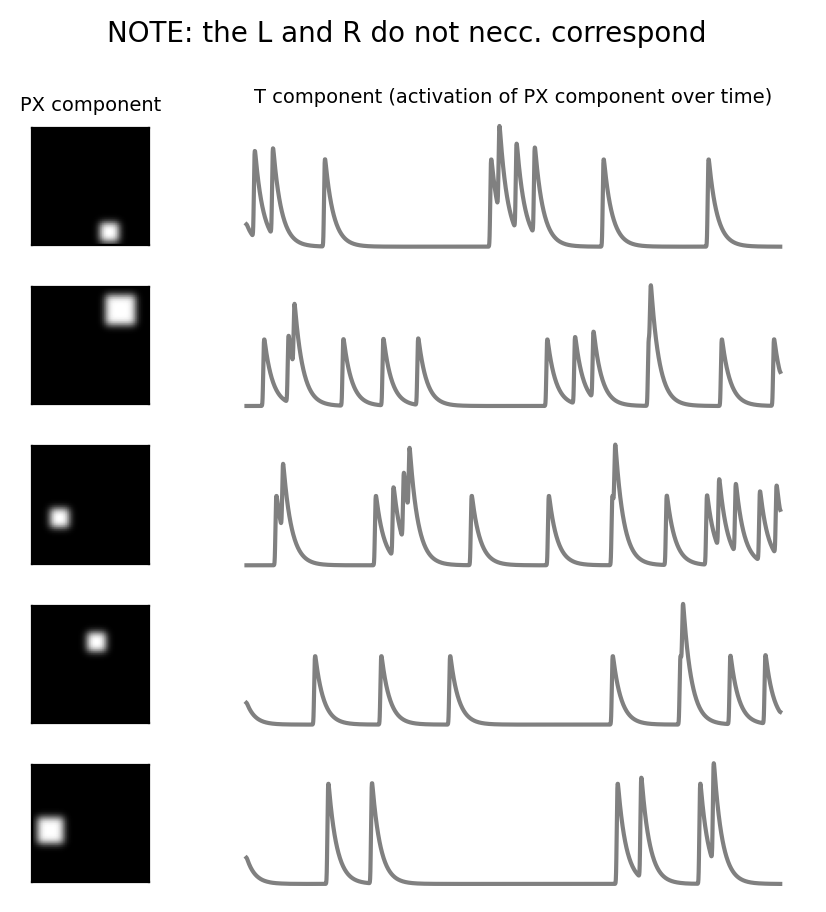

In [16]:
plot_roi_loading_time(truth_pxs, truth_ts, title='Ground truth')

MovieWriter ffmpeg unavailable; using Pillow instead.


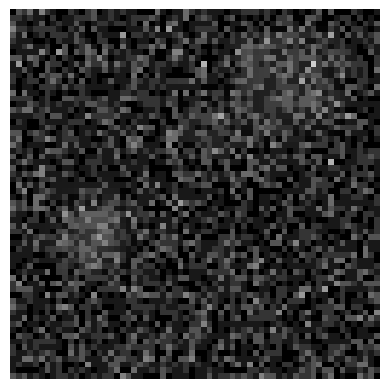

In [17]:
# make animation
animate_movie(movie)

# Running NMF on simulations (this is the same as is done on tiffs of data)

In [18]:
movie_flat = np.reshape(movie, (movie.shape[0] , movie.shape[1]*movie.shape[2]))
print(f'Shape of video as a matrix (input to NMF): {movie_flat.shape}') 

Shape of video as a matrix (input to NMF): (2056, 4096)


In [19]:
# run nmf on pixels
nmf_px = NMF(n_components=n_components)
nmf_px.fit(movie_flat);

In [20]:
loading_imgs, loading_imgs_filt, rois_auto = compute_nmfpx_blur_thr(nmf_px, movie.shape, blur_std=blur_std)

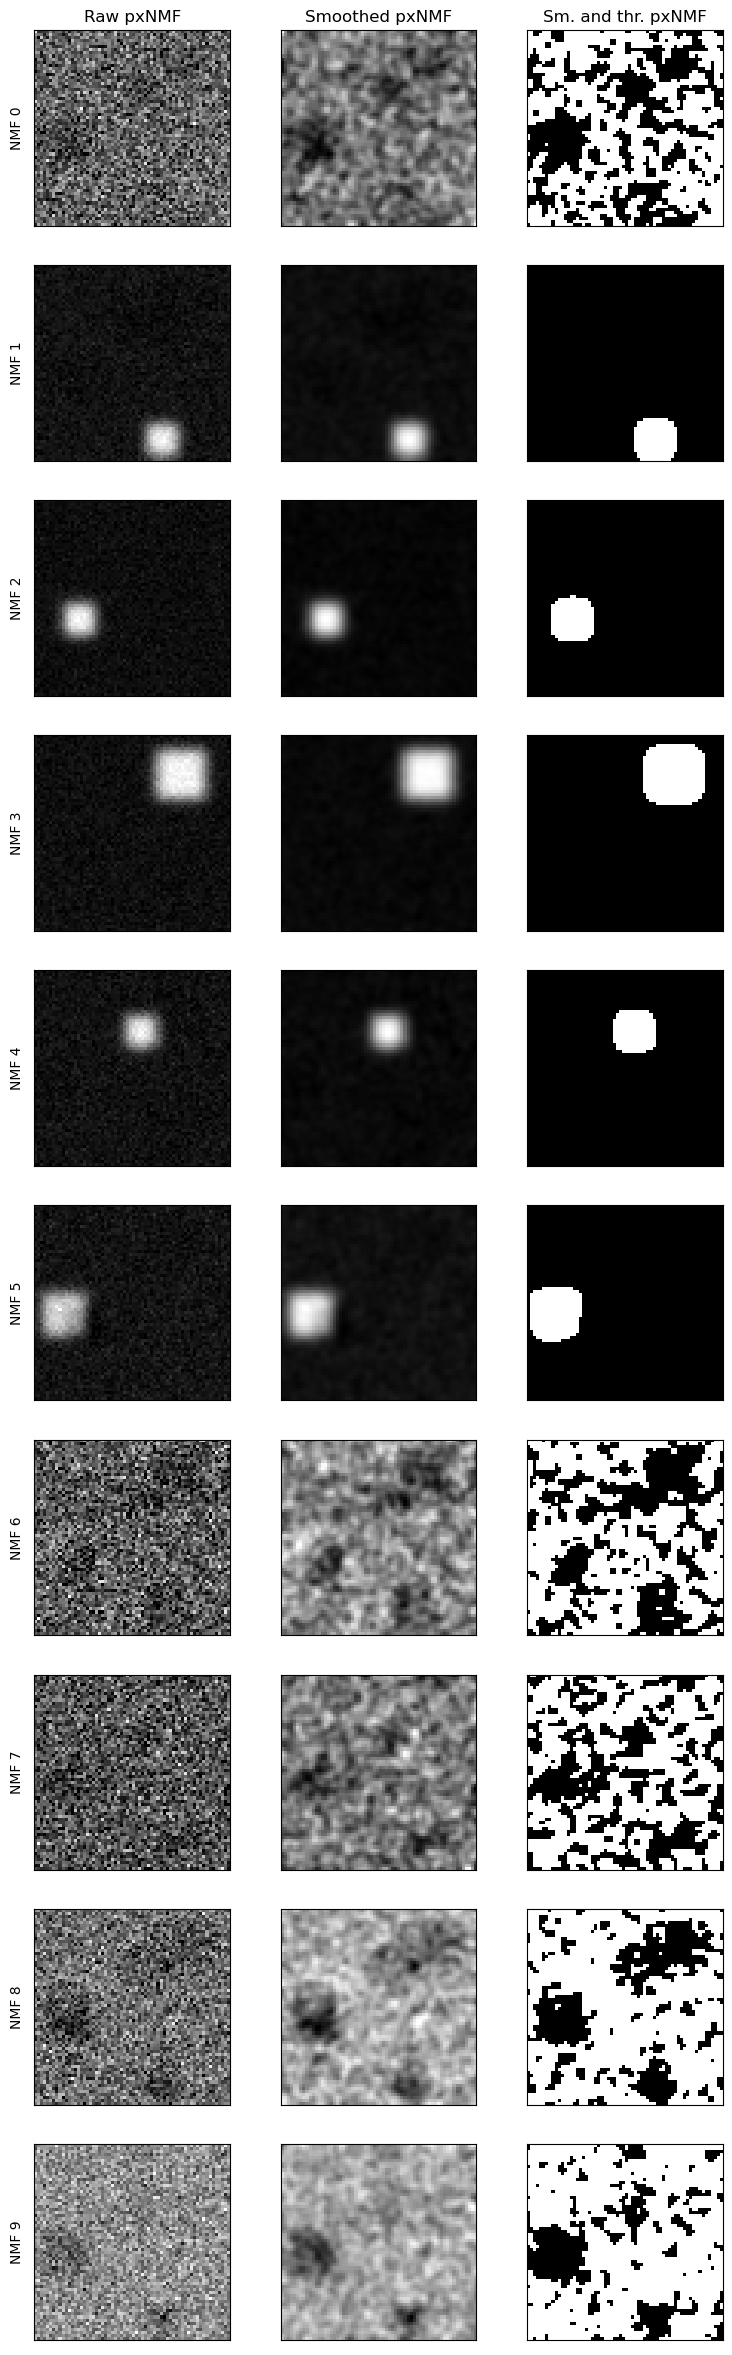

In [21]:
plot_nmfpx_blur_thr(loading_imgs, loading_imgs_filt, rois_auto)

In [22]:
# run nmf on time
nmf_t = NMF(n_components=n_components)
nmf_t.fit(movie_flat.T);

In [23]:
loading_times = get_loading_times(nmf_t)

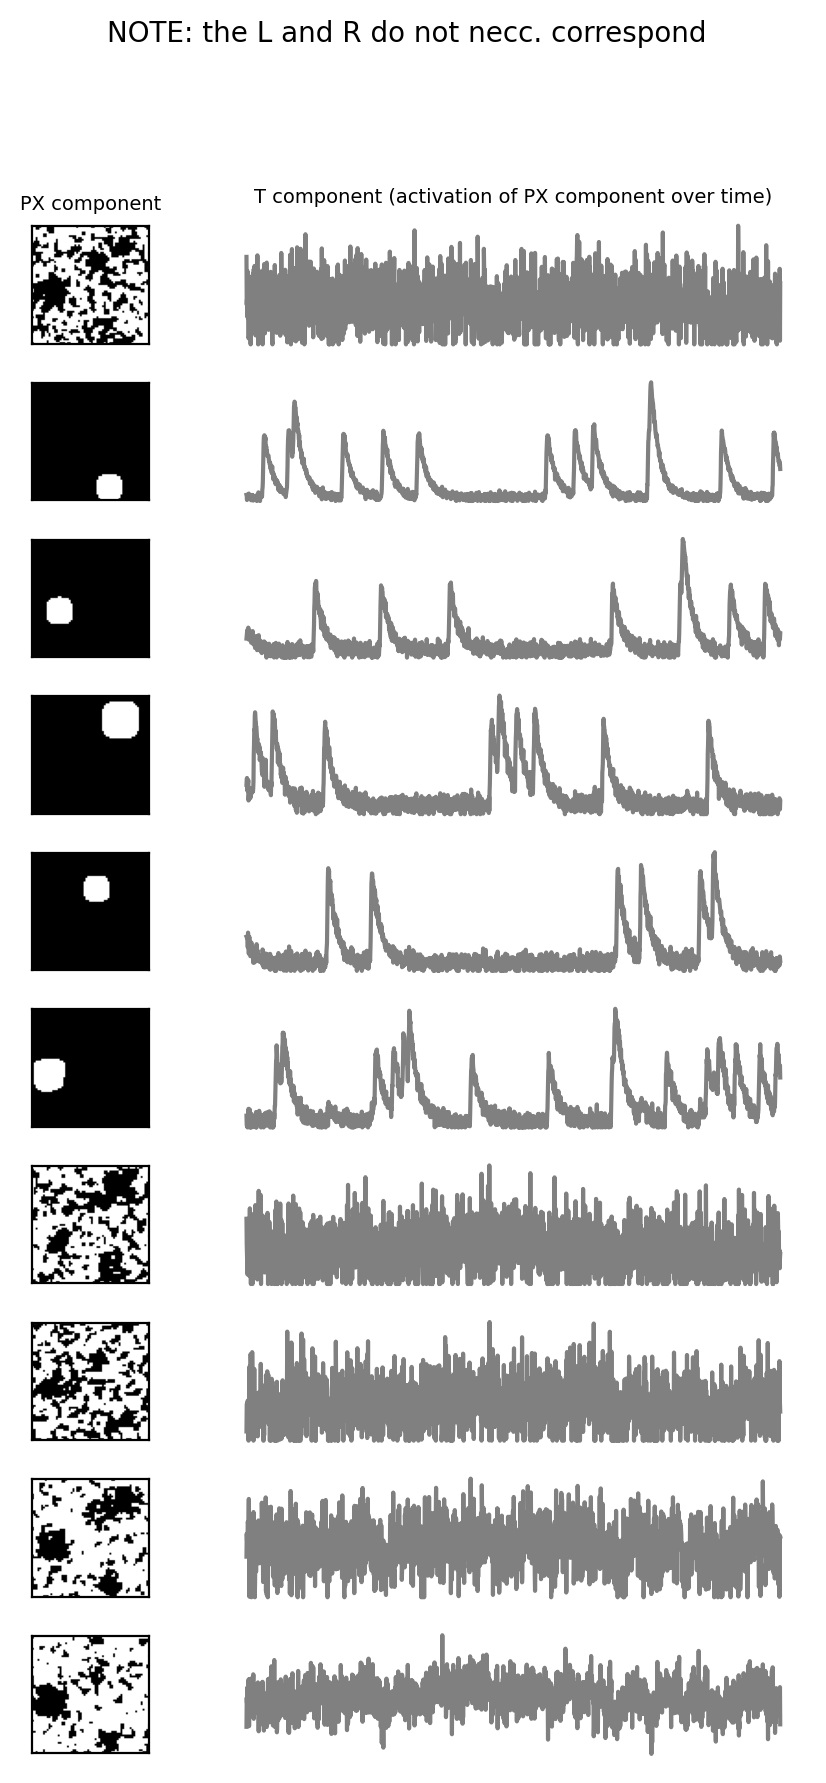

In [24]:
plot_roi_loading_time(rois_auto, loading_times)

Sorting by indices (maxima along columns): [0 0 2 1 3 4 4 1 3 1]



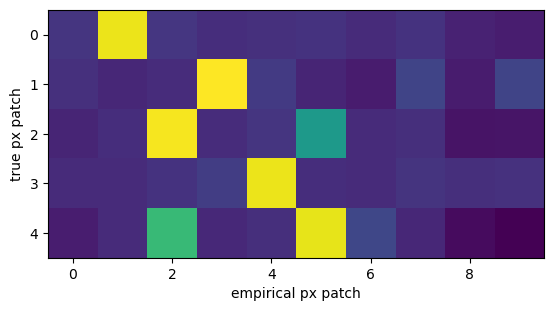

In [25]:
sort_ind_px = covariance_sort(truth_pxs, loading_imgs)

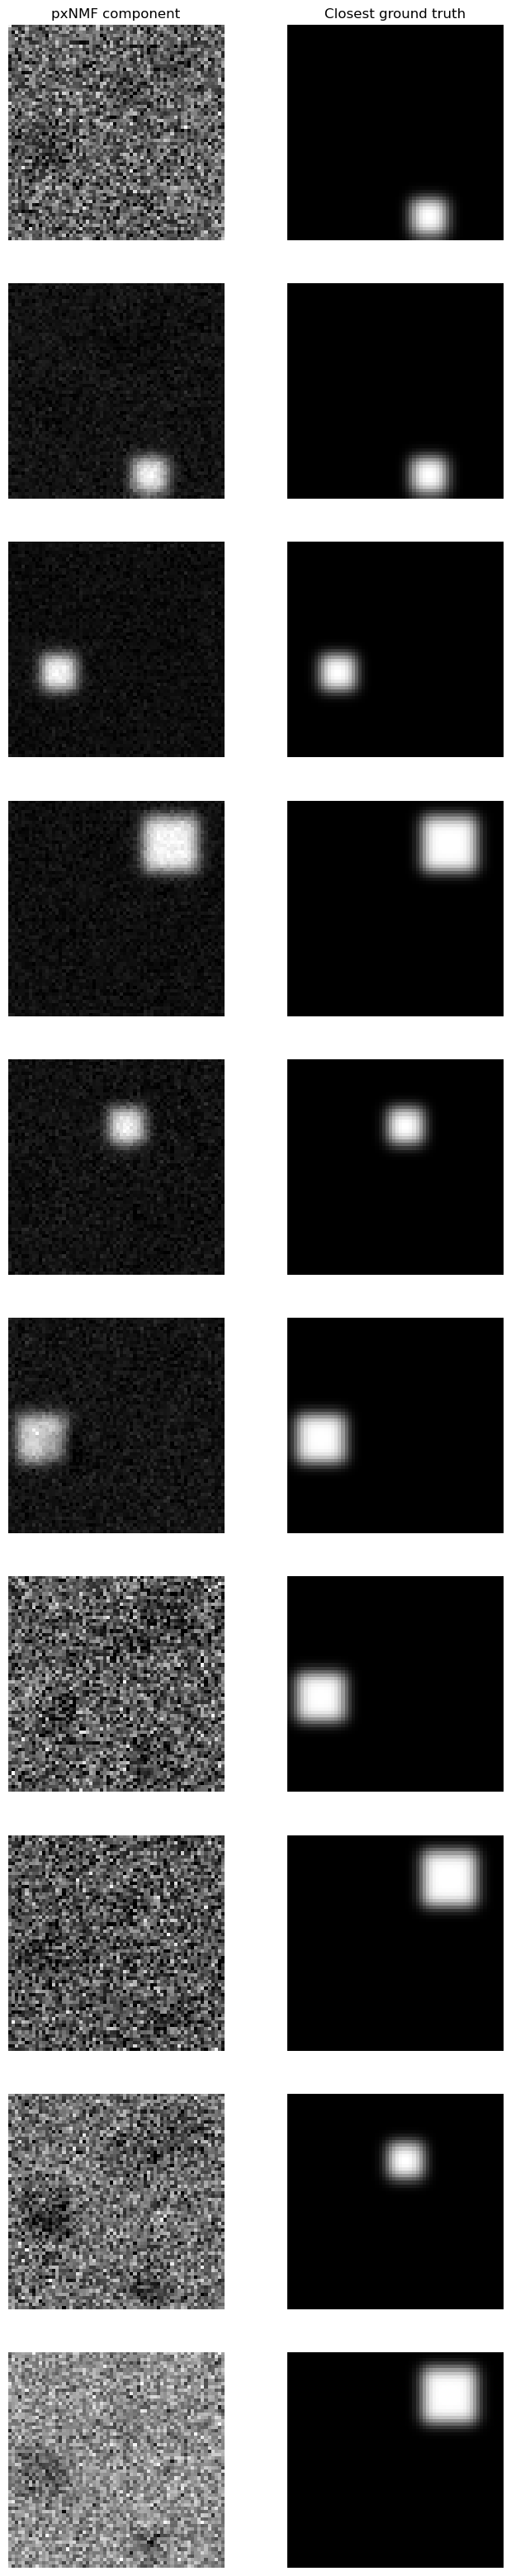

In [26]:
plot_compare_px_truth_nmf(sort_ind_px, truth_pxs, loading_imgs)

Sorting by indices (maxima along columns): [1 1 3 0 4 2 0 1 0 0]



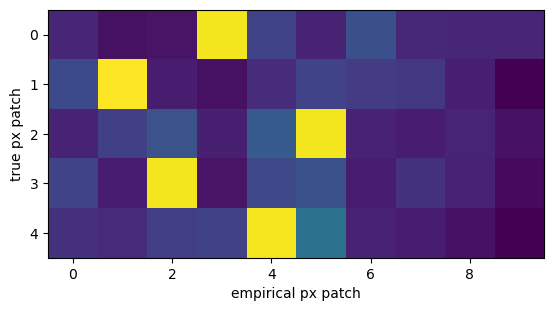

In [27]:
sort_ind_t = covariance_sort(truth_ts, loading_times)

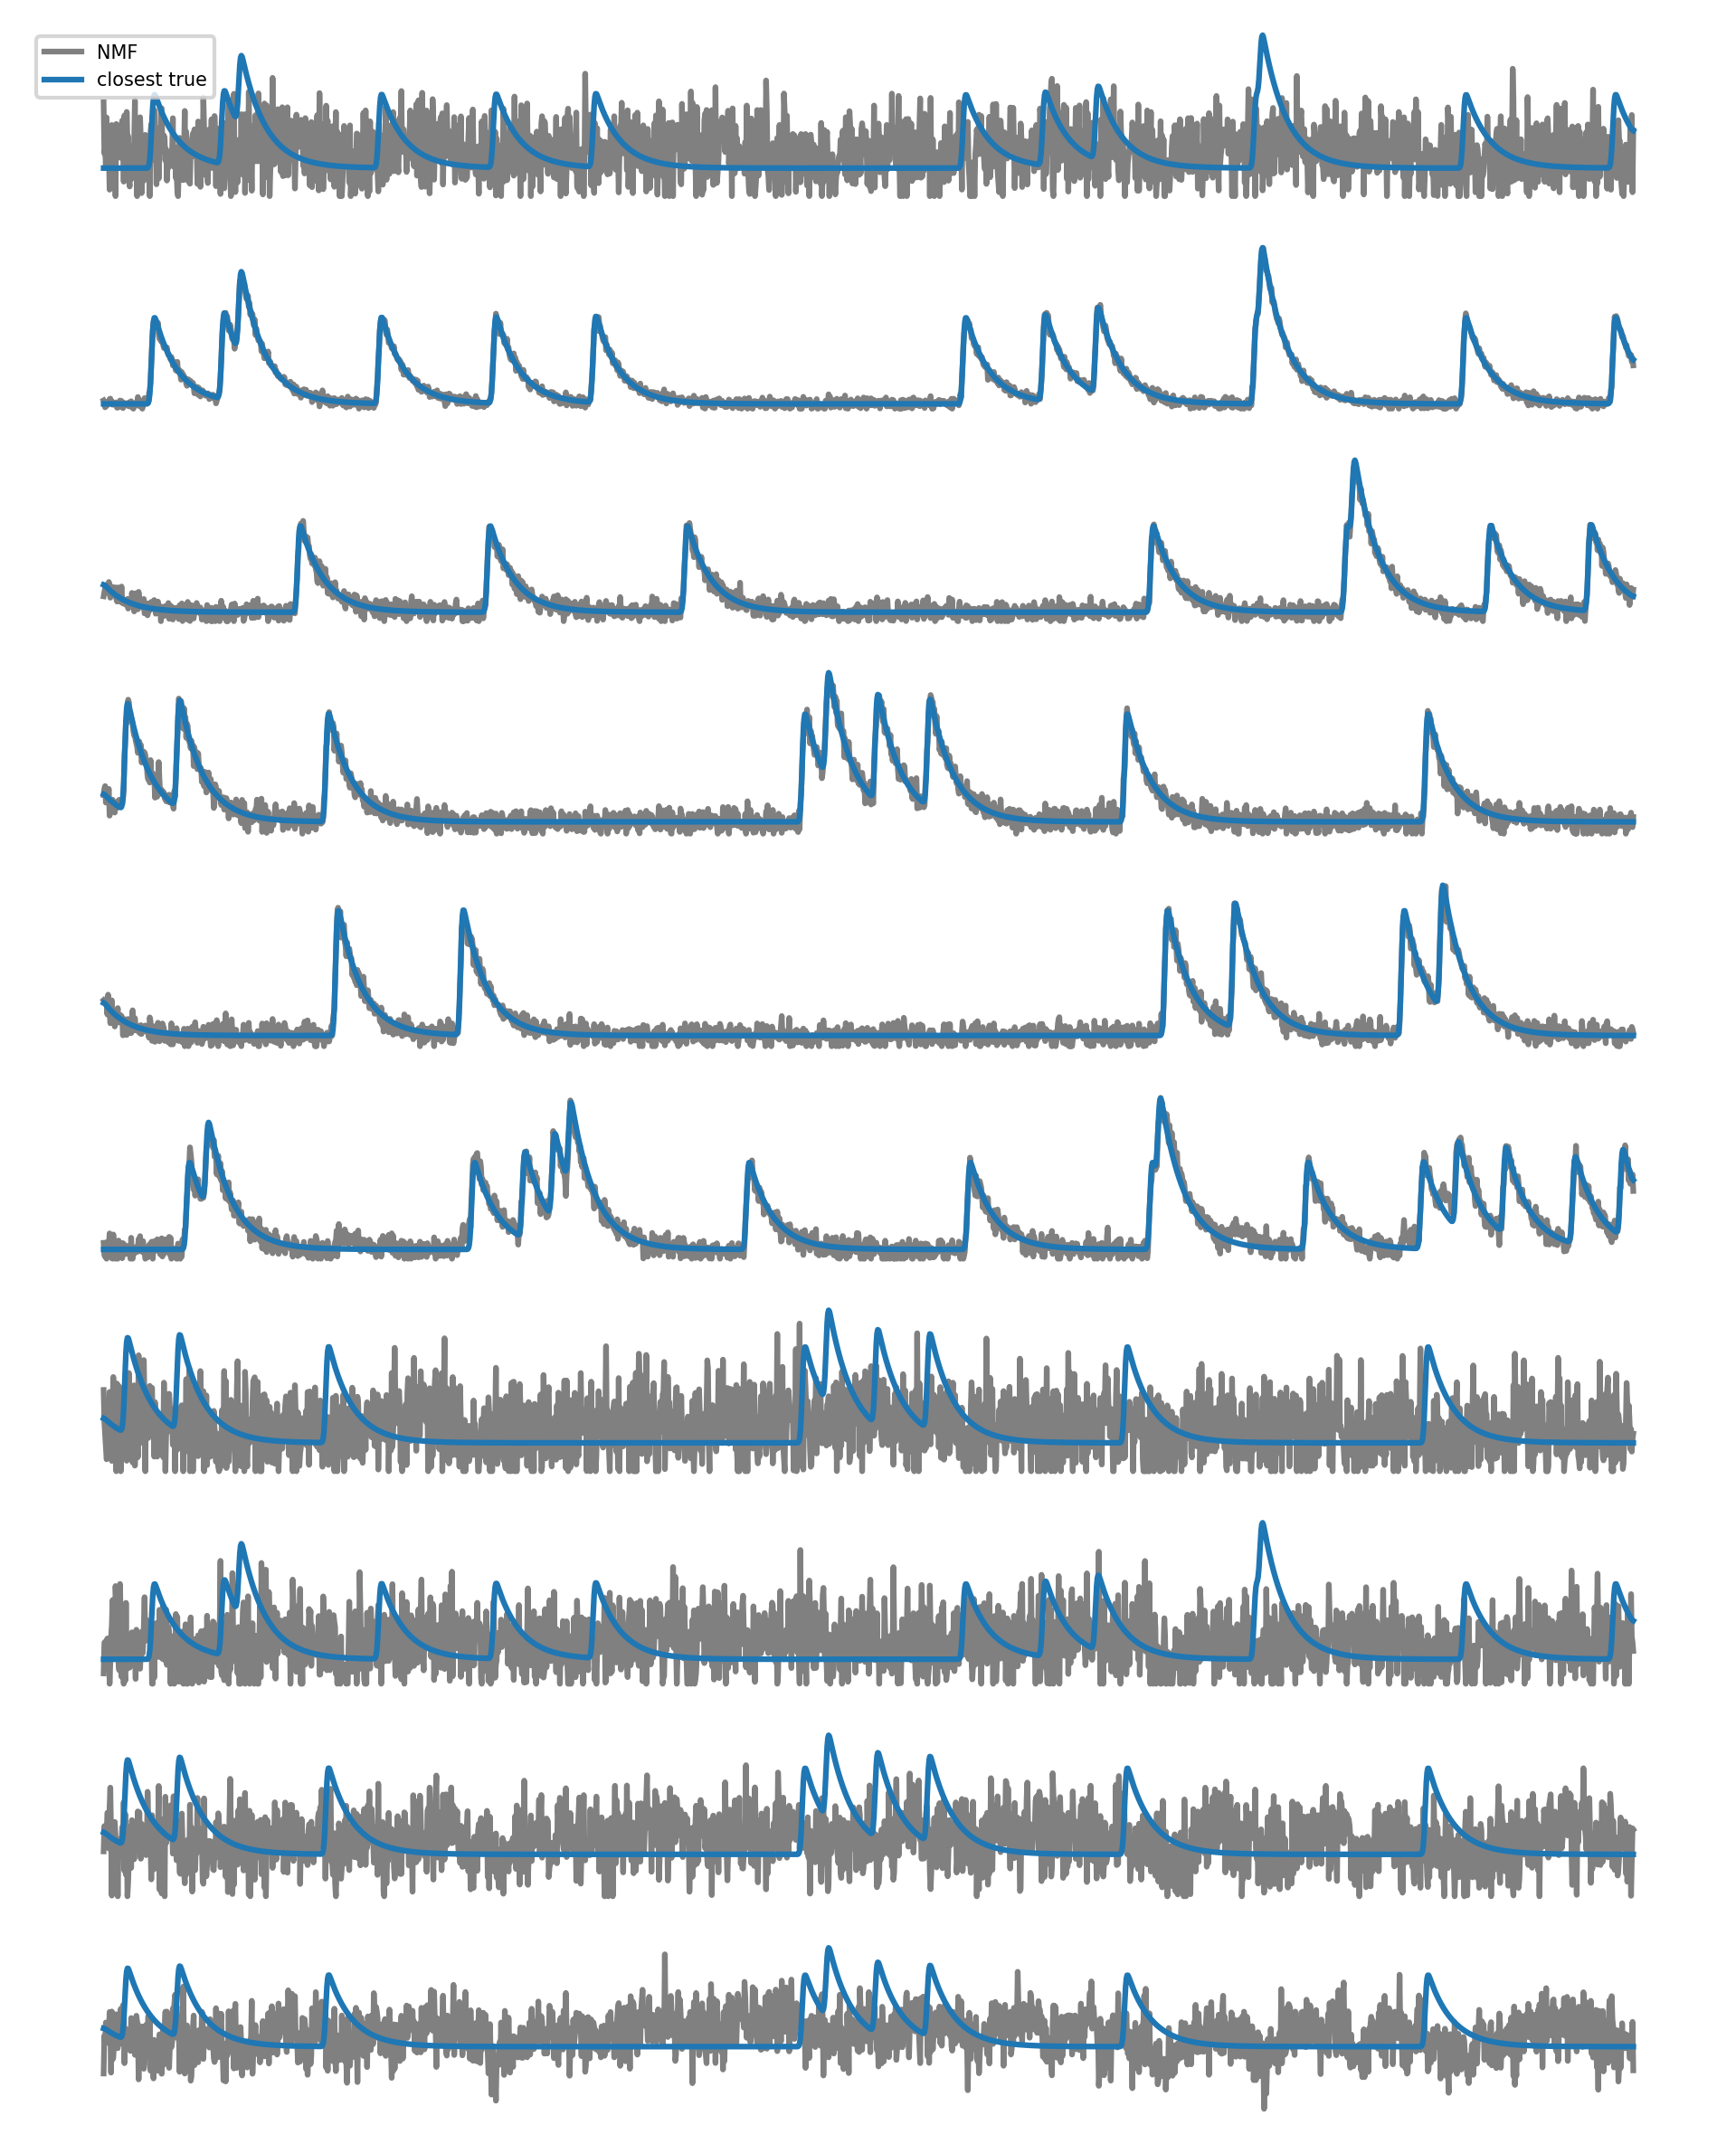

In [28]:
plot_compare_t_truth_nmf(sort_ind_t, truth_ts, loading_times)

# Cross-validation

In [29]:
train_err, test_err = cv_nmf(r_max, step, replicates)

finished running for rank: 0 out of 10 (step = 1)
finished running for rank: 1 out of 10 (step = 1)
finished running for rank: 2 out of 10 (step = 1)
finished running for rank: 3 out of 10 (step = 1)
finished running for rank: 4 out of 10 (step = 1)
finished running for rank: 5 out of 10 (step = 1)
finished running for rank: 6 out of 10 (step = 1)
finished running for rank: 7 out of 10 (step = 1)
finished running for rank: 8 out of 10 (step = 1)
finished running for rank: 9 out of 10 (step = 1)


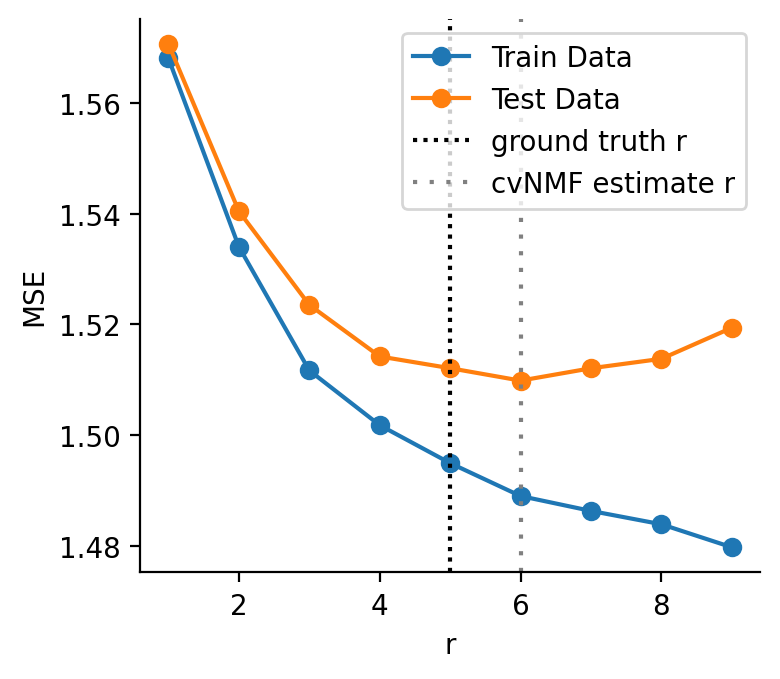

In [30]:
plot_cv_opt(params, train_err, test_err)